In [1]:
import numpy as np
import pandas as pd

from scipy.fftpack import fft, ifft, dct, idct

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba

%matplotlib inline

In [2]:
def figure(figsize=(10, 5)):
    plt.figure(figsize=figsize)

In [3]:
c1 = '#2b2a2b'
c2 = '#863234'
c3 = '#9f847b'

# Correlation Function

\begin{align}
     C_{AB}(\tau) \equiv \langle A B \rangle(\tau) 
         = \lim_{t_0 \rightarrow \infty} ~ \frac{1}{t_0} \int_0^{t_0} \mathrm d t ~ 
             A (t + \tau) ~ B (t)
\end{align}

In [4]:
def correlate(f1, f2):
    t0 = min(len(f1), len(f2))
    
    corr = np.zeros(t0)
    
    for t in range(t0):
        corr[t] = f1[t : t0] @ f2[: t0 - t]
        
    return corr / t0

In [5]:
# Reference data: fast + slow oscillation

t_max = 40
dt = 0.01
w1 = 1 / 1
w2 = 1/ 13

A1 = 1
A2 = 0.33

t = np.arange(0, t_max+dt, dt)
N = len(t)

In [6]:
# noise
rand = np.random.RandomState(0)

noise = (1 * rand.randn(len(t)) * ( 1 - np.exp(- t / 10)))

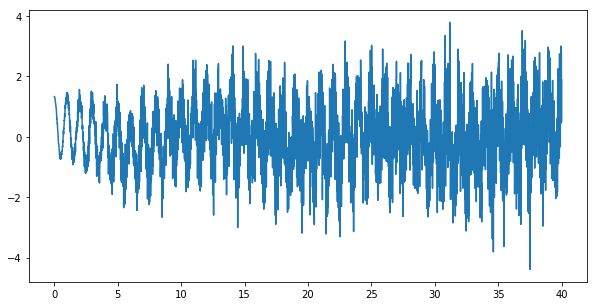

In [7]:
f = A1 * np.cos(2*np.pi * w1 * t) + A2 * np.cos(2*np.pi * w2 * t) + noise

figure()
plt.plot(t, f)

In [8]:
# mean and variance
print(f'{f.mean():.5f} +- {f.var():.5f}')

-0.01077 +- 1.15282


1.1529335549751403


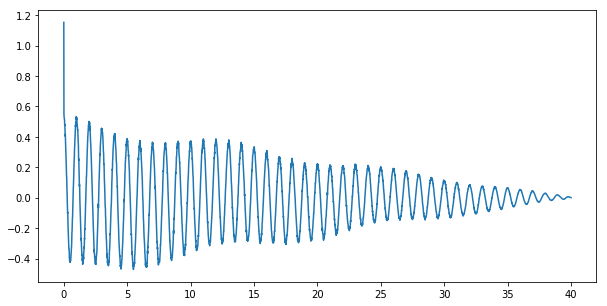

In [9]:
C = correlate(f, f)

figure()
plt.plot(t, C)

print(C[0])

0.5074741587282042


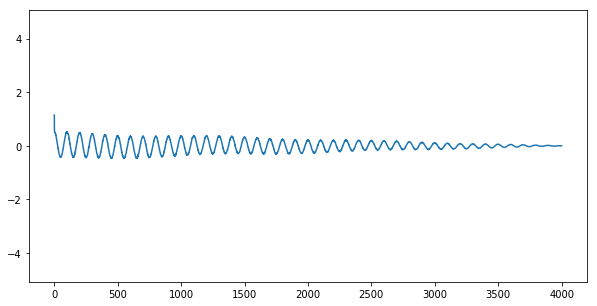

In [10]:
C2 = np.correlate(f, f, 'full')[len(f)-1:] / len(f)

figure()
plt.plot(C2)

plt.ylim([-10* C2[1:10].mean(), 10 * C2[1:10].mean()])

print(C2[1:10].mean())

In [11]:
all(C == C2)

True

# Spectral Density / Power Spectrum

\begin{align}
     S(\omega) 
         = \left\vert ~
         \int_{-\infty}^{\infty} \mathrm d t ~ f(t) ~ \mathrm e^{- \mathrm i \omega t} 
         ~ \right\vert^2
\end{align}

In [12]:
k = np.linspace(0, 1 / dt, N)

S = abs(fft(f))**2

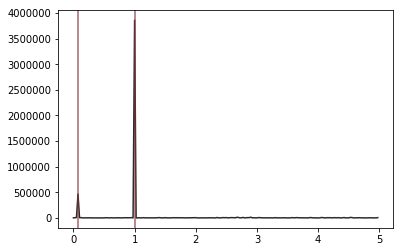

In [13]:
tm = 200
plt.plot(k[:tm], S[:tm], color=c1)
plt.axvline(w1, color=c2, alpha=0.75)
plt.axvline(w2, color=c2, alpha=0.75)

# Wiener Khintchine Theorem

\begin{align}
     S(\omega) 
         = \int_{-\infty}^{\infty} \mathrm d \tau ~ 
             C(\tau) ~ \mathrm e^{- \mathrm i \omega \tau}
         = 2 \int_{0}^{\infty} \mathrm d \tau ~ 
             C(\tau) ~ \cos(\omega \tau)
\end{align}

In [14]:
k = np.linspace(0, 1 / 2 / dt, N)

In [15]:
SWK = 2 * dct(C)

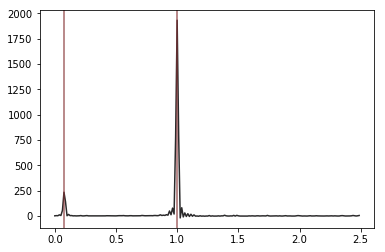

In [16]:
tm = 200
plt.plot(k[:tm], SWK[:tm], color=c1)
plt.axvline(w1, color=c2, alpha=0.75)
plt.axvline(w2, color=c2, alpha=0.75)

\begin{align}
     C(\tau) 
         = \frac{1}{2 \pi} \int_{-\infty}^{\infty} \mathrm d \omega ~ 
             S(\omega) ~ \cos(\omega \tau)
\end{align}

In [17]:
C3 = idct(S)
C4 = idct(SWK)

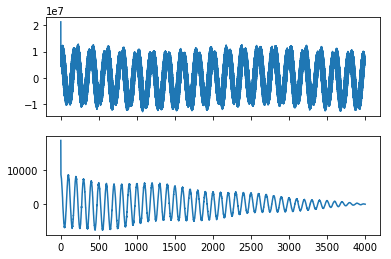

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(C3)
ax2.plot(C4)

# Telegraph Equation
\begin{align}
     X(t) = (-1)^{N(t)}~,
\end{align}

where $N(t)$ is the number of events generated by a Poisson process in the time interval $[0, t)$.

A Poisson process can be modelled as and infinitely dense series of coin tosses with a probability

$$ P(\text{Head}) = \lambda \mathrm d t $$
to flip a head.

The probability of tossing $n$ times a head within $[0, t)$ is then given by

$$ P(N=n, t) = \frac{(\lambda t)^n ~ \mathrm{e}^{-\lambda t}}{n!}~.$$

See https://www.probabilitycourse.com/chapter11/11_1_2_basic_concepts_of_the_poisson_process.php

In [19]:
lam = 2

nt = 10000
ts = np.linspace(0, 20, nt)
dt = ts[1] - ts[0]
dt, lam * dt

(0.002000200020002, 0.004000400040004)

In [20]:
sample = np.zeros(nt)

rand = np.random.RandomState(0)
rands = rand.rand(nt)
sample[rands < lam*dt] = 1
sample.sum()

50.0

In [21]:
signal = (-1) ** sample.cumsum()

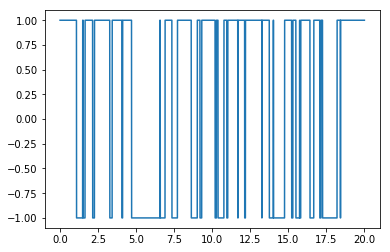

In [22]:
plt.plot(ts, signal)

In [23]:
%time
C_telegraph = correlate(signal, signal)
# C_telegraph = np.correlate(signal, signal, mode='full')[nt-1:] / nt

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


Text(0.5,0,'$\\tau$')

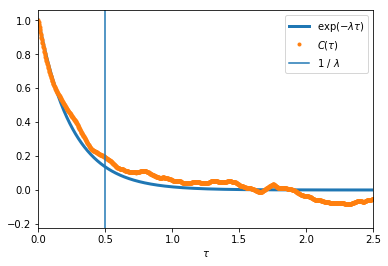

In [24]:
fig, ax = plt.subplots()

ax.plot(ts, np.exp(-  2 * ts * lam), linewidth=3)
ax.plot(ts, C_telegraph, '.')
ax.set_xlim([0, 5 * 1 / lam])
ax.axvline(1 / lam)

ax.legend([r'$\exp(- \lambda \tau)$', r'$C (\tau)$', '1 / $\lambda$'])
ax.set_xlabel(r'$\tau$')